<img src="labori_labs.png" style="float: left; margin: 50px; height: 70px">

# Instacart Network Analysis
--- 

<br>
<br>
<br>
<br>


- <b>Business Problem:</b> <br>
Instacart wants to understand which of products are bought together by their repeat users to more intelligently drive their recommendations and offers.



- <b>Approach:</b> <br>
Network analysis was used to understand how each product relates to one another. This allows us to understand which products are most "well connected" and which group types exist. <br>
In this graph each product is a node and every time two products were purchased in an order counts as a weight in the edge.

- <b>Data:</b> <br>
https://www.kaggle.com/c/instacart-market-basket-analysis

### Takeaways, Recommendations, Next Steps
--- 

<b>Takeaways</b> <br>
- Instacart repeat users buy mostly produce, with 76% of all orders having produce is them
- Looking at products, Bananas both single or in bag are the most well connected products by the number of degrees. Bananas alone connect with 40% of all other products.
- Looking at products that are bought together by department, produce is most bought with itself and with egg dairy
- 79% of all users bought bananas and they have higher order size (~ 13 products per order) than users that did not buy bananas (~9 products per order)

<b>Recommendations</b> <br>
- For new users, the advantages of buying produce from Instacart can be displayed in ads or in the app as first recommended.
- For current users to stay in the platform, the price sensitivity of produce have to be kept into account. Produce is the reason they stay and buy other products.
- Realize the importance of bananas in the Instacart platform in order to run promotions or keep the price low.

<b>Next Steps</b> <br>
- Get prices for each product in order to see which departments earn more money
- Get more data to compare new customers vs returning customers, most data here was returning customers


In [99]:
import pandas as pd
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import dzcnapy_plotlib as dzcnapy
from scipy import stats
import seaborn as sns

%matplotlib inline

### a. Load & Summary Statistics
--- 

In [2]:
instacart_df = pd.read_csv('instacart.csv').iloc[:,1:]

In [3]:
instacart_df.head(2)

,order_id,user_id,add_to_cart_order,product_id,product_name,aisle_id,aisle,department,order_hour_of_day,days_since_prior_order,order_dow,reordered
0,23391,7,1,13198,85% Lean Ground Beef,122,meat counter,meat seafood,10,28.0,0,1
1,23391,7,2,42803,Organic Apple Slices,50,fruit vegetable snacks,snacks,10,28.0,0,1


In [4]:
instacart_df.describe()

,order_id,user_id,add_to_cart_order,product_id,aisle_id,order_hour_of_day,days_since_prior_order,order_dow,reordered
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,468026.000000,500000.000000,500000.000000
mean,26400.108476,103246.307530,8.348422,25564.192186,71.207052,13.430762,11.001669,2.737464,0.590246
std,15262.554968,59440.331665,7.115773,14100.724459,38.206874,4.264669,8.675150,2.085868,0.491789
min,2.000000,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,13208.000000,51748.000000,3.000000,13514.000000,31.000000,10.000000,5.000000,1.000000,0.000000
50%,26350.000000,103035.000000,6.000000,25246.000000,83.000000,13.000000,8.000000,3.000000,1.000000
75%,39561.000000,155185.000000,11.000000,37849.000000,107.000000,16.000000,15.000000,5.000000,1.000000
max,52883.000000,206208.000000,92.000000,49688.000000,134.000000,23.000000,30.000000,6.000000,1.000000


In [5]:
instacart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                500000 non-null  int64  
 1   user_id                 500000 non-null  int64  
 2   add_to_cart_order       500000 non-null  int64  
 3   product_id              500000 non-null  int64  
 4   product_name            500000 non-null  object 
 5   aisle_id                500000 non-null  int64  
 6   aisle                   500000 non-null  object 
 7   department              500000 non-null  object 
 8   order_hour_of_day       500000 non-null  int64  
 9   days_since_prior_order  468026 non-null  float64
 10  order_dow               500000 non-null  int64  
 11  reordered               500000 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 45.8+ MB


We will also create a new dataframe for repeat users

In [6]:
reorder_user_id = instacart_df.query("reordered == 1").user_id.unique()
reorder_df = instacart_df[instacart_df.user_id.isin(reorder_user_id)]

In [7]:
print('Total rows of all data:', instacart_df.shape[0])
print('Total rows of reordered data:', reorder_df.shape[0])
print('Loss of:' ,round((1 - (reorder_df.shape[0]/instacart_df.shape[0])) * 100, 2),'% of rows' )

Total rows of all data: 500000
Total rows of reordered data: 462874
Loss of: 7.43 % of rows


### B. Top Products
--- 

The products that are most sold are ofter the ones that are most connected. So before we see the most connected products we will see the most sold products, deportments, and aisle.

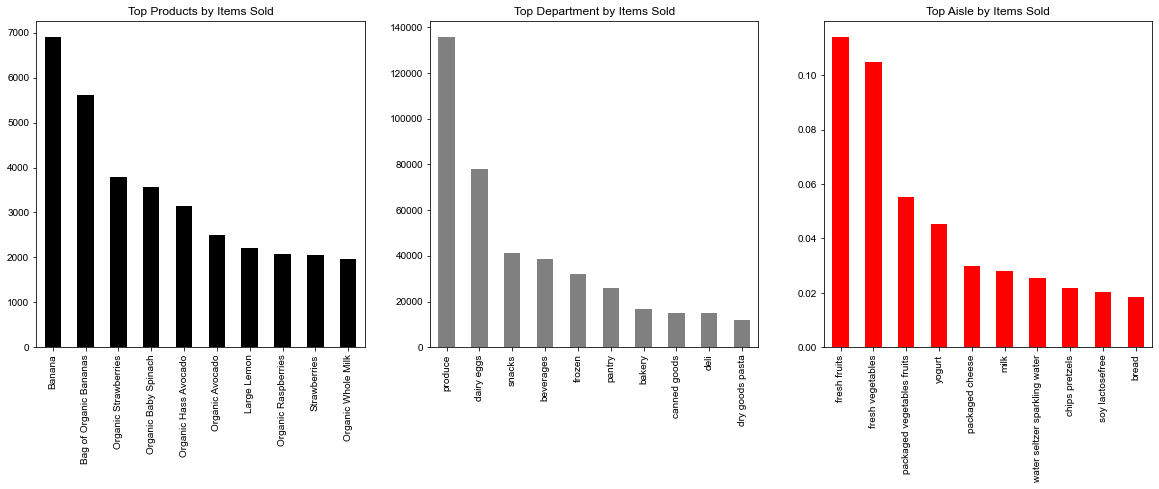

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(20,6))

reorder_df.product_name.value_counts().head(10).plot(kind = 'bar', ax = ax[0])
ax[0].title.set_text('Top Products by Items Sold')

reorder_df.department.value_counts().head(10).plot(kind = 'bar', ax = ax[1], color = 'grey')
ax[1].title.set_text('Top Department by Items Sold')

(reorder_df.aisle.value_counts()/reorder_df.shape[0]).head(10).plot(kind = 'bar', ax = ax[2], color = 'red')
ax[2].title.set_text('Top Aisle by Items Sold')

- Bananas and Bag of Organic Bananas are the biggest sellers

- Fresh fruits, fresh vegetables have almost double the percentage as other aisles


- Produce accounts for almost 30% of all sales
- Followed by Dairy Eggs with 16%
- Produce and Dairy Eggs account for almost 50% of all sales

### B.Network Analysis
--- 

Steps:
- Create a network graph with instacart data
- See the density of the graph, to see how linked the product are
- The edge distribution, to see how many products are highly connected
- Find the most connected product

<b> Turning products into top binary combinations

In [9]:
products_by_order = reorder_df.query("reordered == 1").groupby('order_id')['product_name'].apply(list)
product_combinations = [[set(comb) for comb in combinations(i, 2)] for i in products_by_order]
joint_combinations = ['|'.join(sorted(list(item))) for sublist in product_combinations for item in sublist]
product_combinations = Counter(joint_combinations)

In [10]:
product_combinations.most_common(10)

[('Bag of Organic Bananas|Organic Hass Avocado', 760),
 ('Bag of Organic Bananas|Organic Strawberries', 695),
 ('Banana|Organic Strawberries', 678),
 ('Banana|Organic Avocado', 636),
 ('Banana|Organic Baby Spinach', 627),
 ('Bag of Organic Bananas|Organic Baby Spinach', 612),
 ('Bag of Organic Bananas|Organic Raspberries', 503),
 ('Organic Hass Avocado|Organic Strawberries', 463),
 ('Banana|Strawberries', 447),
 ('Banana|Large Lemon', 433)]

- The top binary combinations are bag of organic bananas & organic has avocado
- The top combinations are all produce

<b> Creating a Network Graph

In [11]:
# instantiating the network
insta_nx = nx.Graph()

# Adding nodes
nodes = [item for sublist in [i.split('|') for i in product_combinations.keys()] for item in sublist]
insta_nx.add_nodes_from(nodes)

# edges 
insta_nx.add_edges_from([set(i.split('|')) for i in list(set(product_combinations.keys()))])

#weights
for i in product_combinations:
    
    first,second = i.split('|')
    insta_nx[first][second]['weight'] = product_combinations[i]
    
# set aisle as an attribute for the network    
name_aisle = reorder_df[['product_name',
                           'aisle']].drop_duplicates().set_index('product_name').to_dict()['aisle']
nx.set_node_attributes(insta_nx, name_aisle, name='aisle')

# set department as an attribute for the network    
name_department = reorder_df[['product_name', 
                           'department']].drop_duplicates().set_index('product_name').to_dict()['department']
nx.set_node_attributes(insta_nx, name_department, name='department')    

<b> Network Density <br> </b>
How many connections exist out of all possible connections?    

In [12]:
edges_num = nx.number_of_edges(insta_nx)
edges_not_connected = len(list(nx.non_edges(insta_nx)))

In [16]:
percent = round((edges_num/(edges_num + edges_not_connected))* 100, 2)
print(percentent, '% percent of connections are mode')

0.47 % percent of connections are mode


<b> Degree Distribution <br> </b>
Degree is the number of edges that a node can have. The amount of edges is a way to note the amount of connections a node has. We can see how many nodes have a certain amout of degrees.

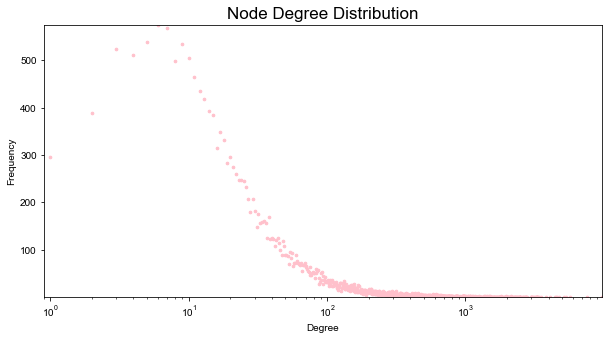

In [27]:
deg = dict(nx.degree(insta_nx))
x, y = zip(*Counter(deg.values()).items())

plt.figure(figsize=(10,5))
plt.scatter(x, y, s=7, c="pink")
plt.xscale("log")
#plt.yscale("log")
plt.xlim(0.9, max(x))
plt.ylim(0.9, max(y))
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title('Node Degree Distribution', size = 17)
plt.show()

<b> Assortativity </b> <br>

How correlated are the departments by nodes connected?

In [34]:
nx.attribute_assortativity_coefficient(insta_nx, "department")

0.031825156204505954

The departments are slightly if at all connected

<b> Attribute Assortavility Matrix </b> <br>

We can see how correlated the department are to one another. Meaning how likely are they to be connected. 

In [29]:
department = {val:i for i,val in enumerate(reorder_df.department.unique())}


attribute_matrix_by_department = pd.DataFrame(nx.attribute_mixing_matrix(insta_nx, 
                                        "department",
                                       mapping = department),
                                        columns = department.keys(),
                                        index = department.keys())

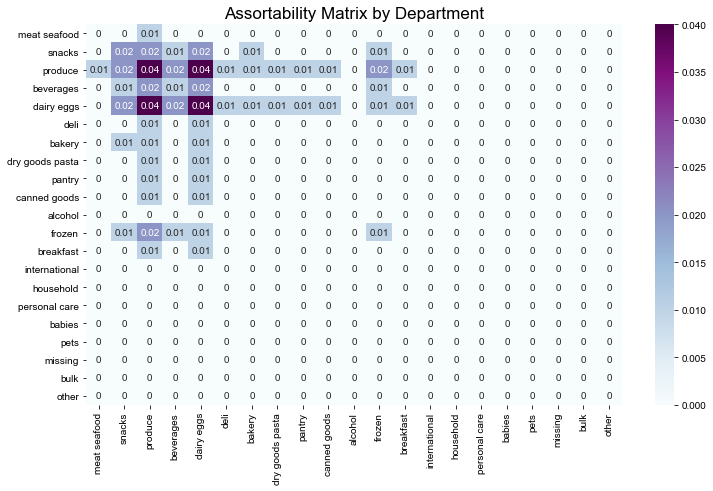

In [36]:
plt.figure(figsize=(12,7))
sns.heatmap(round(attribute_matrix_by_department, 2),cmap="BuPu", annot= True)
plt.title('Assortability Matrix by Department', size = 17)
plt.show()

- Most of the correlation between departments comes from produce being bought together with other producte
- Then there is a slight positive correlation with produce and snacks, beverages, dairy eggs, and frozen

<b> Graph Visualization With Top 6 Nodes </b> <br>

Graphing top 6 departments and how they relate to one another.

In [137]:
dpt_products_by_order = reorder_df[reorder_df.reordered == 1].groupby('order_id')['department'].apply(list)
dpt_product_combinations = [[set(comb) for comb in combinations(i, 2)] for i in dpt_products_by_order]
dpt_joint_combinations = ['|'.join(sorted(list(item))) for sublist in dpt_product_combinations for item in sublist]
dpt_product_combinations = Counter(dpt_joint_combinations)

dpt_nodes = [item for sublist in [i.split('|') for i in dpt_product_combinations.keys()] for item in sublist]
insta_department_nx = nx.Graph()

# nodes
insta_department_nx.add_nodes_from(dpt_nodes)

# edges 
insta_department_nx.add_edges_from([set(i.split('|')) for i in list(set(dpt_product_combinations.keys())) if len(i.split('|')) > 1])

#weights
for i in dpt_product_combinations:
    
    if len(i.split('|')) > 1:
        first,second = i.split('|')
        insta_department_nx[first][second]['weight'] = dpt_product_combinations[i]

In [141]:
dpt_product_combinations.most_common(5)

[('produce', 195347),
 ('dairy eggs|produce', 177065),
 ('produce|snacks', 71400),
 ('dairy eggs', 64378),
 ('beverages|produce', 62777)]

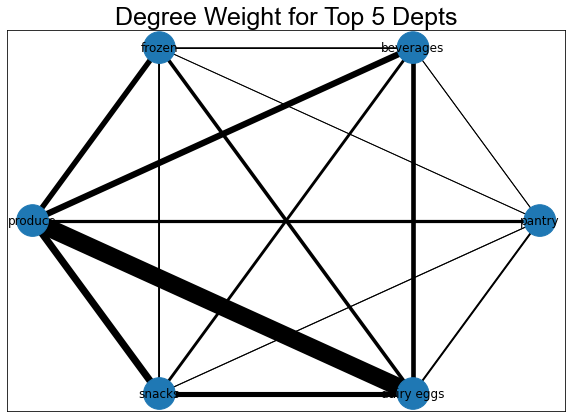

In [181]:
sub_nx = nx.subgraph(insta_department_nx, reorder_df.department.value_counts().index[:6])

plt.figure(figsize=(10,7))

pos = nx.circular_layout(sub_nx)
nx.draw_networkx(sub_nx, pos,node_size = [1000 for i in range(6)])

for edge in sub_nx.edges(data='weight'):
    nx.draw_networkx_edges(sub_nx, pos, edgelist=[edge], width=edge[2] * .0001)
    
plt.title('Degree Weight for Top 5 Depts', size = 25)
plt.show()

- Dairy Eggs & Produce have the strongest connection
- Produce is the most well connected department

<b> Most Connected Product </b>

New we can see which product is most connected. This can be done by the number of degrees that the node has.

In [37]:
dgr = nx.degree_centrality(insta_nx)

In [39]:
sorted(dgr.items(), key = lambda x: x[1], reverse = True)[:10]

[('Banana', 0.46984034551366044),
 ('Bag of Organic Bananas', 0.3646333770078129),
 ('Organic Strawberries', 0.2765565099238123),
 ('Organic Hass Avocado', 0.26029989809288107),
 ('Organic Baby Spinach', 0.2504488765953317),
 ('Organic Avocado', 0.22929101761537343),
 ('Strawberries', 0.22458387926432766),
 ('Organic Raspberries', 0.21919736012034746),
 ('Large Lemon', 0.2150725481632455),
 ('Limes', 0.19760275634493135)]

- The most connected product by degrees is banana and bag of organic bananas
- Bananas is connected to 46% of all the products
- Bag of Organic Bananas is bought with 36% of the products

### C. Exploring Bananas 

It would be useful to explore banana's influence in the size of the orders and the average time since the last order. 

Are bananas linked to people buying more products per order?

In [43]:
banana_order_id = reorder_df[reorder_df.product_name.isin(('Banana', 'Bag of Organic Bananas'))].order_id.unique()

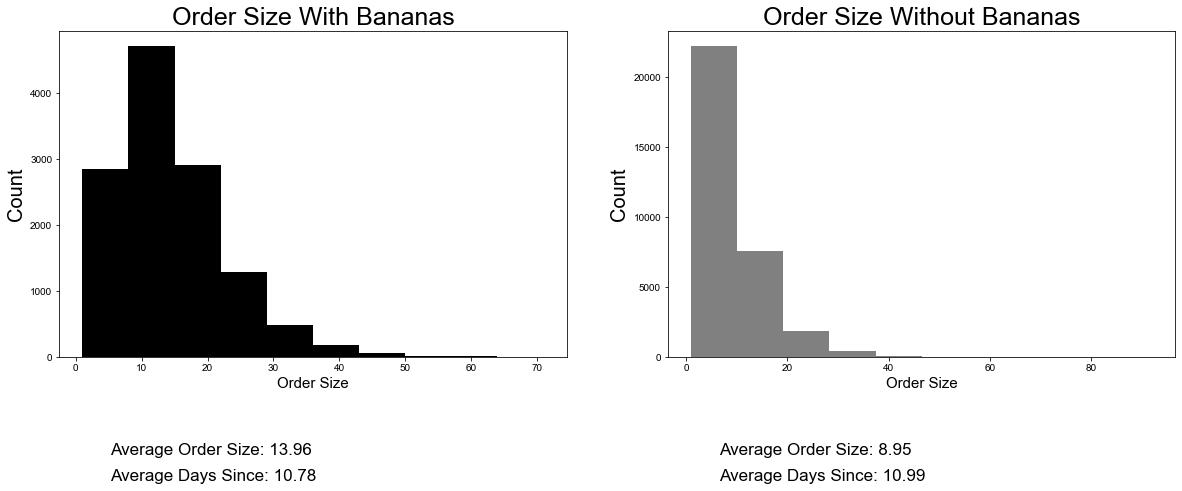

In [100]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))


banana_size = reorder_df[reorder_df.order_id.isin(banana_order_id)].groupby('order_id').count().product_name
ax[0].hist(banana_size)
ax[0].set_title('Order Size With Bananas', fontsize = 25)
ax[0].set_ylabel('Count', fontsize = 20)
ax[0].set_xlabel('Order Size', fontsize = 15)
ax[0].text(0.1,-0.3, f"Average Order Size: {round(banana_size.mean(),2)}", size=17, 
         transform=ax[0].transAxes)

avg_days_since = round(reorder_df[reorder_df.order_id.isin(banana_order_id)].days_since_prior_order.mean(), 2)
ax[0].text(0.1,-0.38, f"Average Days Since: {avg_days_since}", size=17,
         transform=ax[0].transAxes)



non_banana_size = reorder_df[-reorder_df.order_id.isin(banana_order_id)].groupby('order_id').count().product_name
ax[1].hist(non_banana_size, color = 'grey')
ax[1].set_title('Order Size Without Bananas', fontsize = 25)
ax[1].set_ylabel('Count', fontsize = 20)
ax[1].set_xlabel('Order Size', fontsize = 15)
ax[1].text(0.1,-0.3, f"Average Order Size: {round(non_banana_size.mean(), 2)}", size=17,
         transform=ax[1].transAxes)

avg_days_since = round(reorder_df[-reorder_df.order_id.isin(banana_order_id)].days_since_prior_order.mean(), 2)
ax[1].text(0.1,-0.38, f"Average Days Since: {avg_days_since}", size=17, 
         transform=ax[1].transAxes)
plt.show()

- The order size is larger for orders with bananas with an average of ~14 prouducs compared with ~9 products for non bananas
- The average days are similar, this may be due to it being a sample of the data

Are the average order results statistically significant? <br>
We can check this with an independent sample t test and we will look for 95% confidence

In [101]:
stats.ttest_ind(non_banana_size, banana_size, equal_var=False)

Ttest_indResult(statistic=-60.18785645101232, pvalue=0.0)

Our p-values is less than .05 so it is significant

<b> Share of Sales That Have Bananas</b> <br>


In [168]:
banana_orders = reorder_df[reorder_df.order_id.isin(banana_order_id)].order_id.nunique()
total_orders = reorder_df.order_id.nunique()

banana_users = reorder_df[reorder_df.order_id.isin(banana_order_id)].user_id.nunique()
total_users = reorder_df.user_id.nunique()


print(round(banana_orders/total_orders*100, 2), '% of all orders have bananas in them')
print(round(banana_users/total_users*100, 2), '% of all users have bananas in them')

27.98 % of all orders have bananas in them
31.06 % of all orders have bananas in them


<b> Share of Sales that Are Produce


In [170]:
produce_order_id = reorder_df.query("department == 'produce'").order_id.unique()

produce_orders = reorder_df[reorder_df.order_id.isin(produce_order_id)].order_id.nunique()
produce_users = reorder_df[reorder_df.order_id.isin(produce_order_id)].user_id.nunique()

print(round(produce_orders/total_orders*100, 2), '% of all orders have produce in them')
print(round(produce_users/total_users*100, 2), '% of all orders have produce in them')

76.45 % of all orders have produce in them
79.02 % of all orders have produce in them


### Takeaways, Recommendations, Next Steps
--- 

<b>Takeaways</b> <br>
- Instacart repeat users buy mostly produce, with 76% of all orders having produce is them
- Looking at products, Bananas both single or in bag are the most well connected products by the number of degrees. Bananas alone connect with 40% of all other products.
- Looking at products that are bought together by department, produce is most bought with itself and with egg dairy
- 79% of all users bought bananas and they have higher order size (~13 products per order) than users that did not buy bananas (~9 products per order)

<b>Recommendations</b> <br>
- For new users, the advantages of buying produce from Instacart can be displayed in ads or in the app as first recommended.
- For current users to stay in the platform, the price sensitivity of produce have to be kept into account. Produce is the reason they stay and buy other products.
- Realize the importance of bananas in the Instacart platform in order to run promotions or keep the price low.

<b>Next Steps</b> <br>
- Get prices for each product in order to see which departments earn more money
- Get more data to compare new customers vs returning customers, most data here was returning customers